In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

import warnings
warnings.simplefilter('ignore')

# Converstion rate and ways to improve it

## Goal

Conversion is a type of lower funnel objective in terms of funnel analysis. As we perform analysis on advertising or user data, one key metric is conversion, which can be interpreted as conversion from user to advertiser or conversion from upper funnel spend to lower funnel spend. Usually, the goal would be either to understand the conversion rate across different user/advertiser segments and provide further granularity to enrich the dataset or to predict the conversion rate based on the behaviour or characteristic data.

My goal for this project is to create and train a model to predict converstion rate based on exsiting date and improve converstion rate.

## 1. Data understanding and exploratory

In [55]:
df = pd.read_csv('/Users/david/Code_Files/projects/project2/conversion_project.csv')
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


- country : user country based on the IP address (category data)
- age : user age. Self-reported at sign-in step
- new_user : whether the user created the account during this session or had already an account and simply came back to the site
- source : marketing channel source; (category data) 1. Ads: came to the site by clicking on an advertisement. 2. Seo: came to the site by clicking on search results. 3. Direct: came to the site by directly typing the URL on the browser
- total_pages_visited: number of total pages visited during the session. This is a proxy for time spent on site and engagement during the session.
- converted: this is our label. 1 means they converted within the session, 0 means they left without buying anything. 

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              316200 non-null  object
 1   age                  316200 non-null  int64 
 2   new_user             316200 non-null  int64 
 3   source               316200 non-null  object
 4   total_pages_visited  316200 non-null  int64 
 5   converted            316200 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [37]:
df.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [38]:
df.shape

(316200, 6)

## 2. Exploratory Data Analysis (EDA)

### outliers 

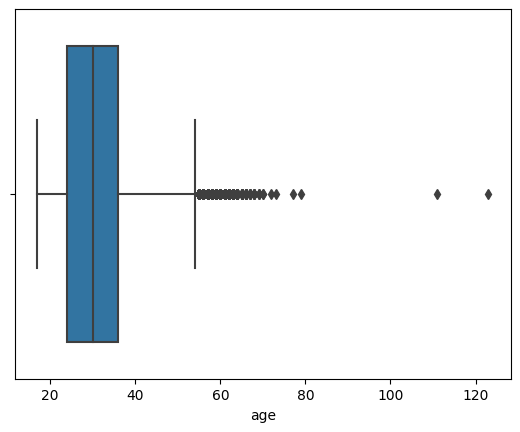

In [39]:
sns.boxplot(x=df['age'])
plt.show()

As you can see, there are two obvious outliers for age, where we can drop them from df

In [40]:
df = df[df.age<= 100]

### individual variable analysis 
- For categorical variables like country, new_user and source, bar plots or pie charts are perfect to visualize the distribution of each category.
- For numerical variables like age and total_pages_visited, histograms, box plots, or density plots are to visualize the distribution. This can help identify skewness, outliers, and other distribution properties.

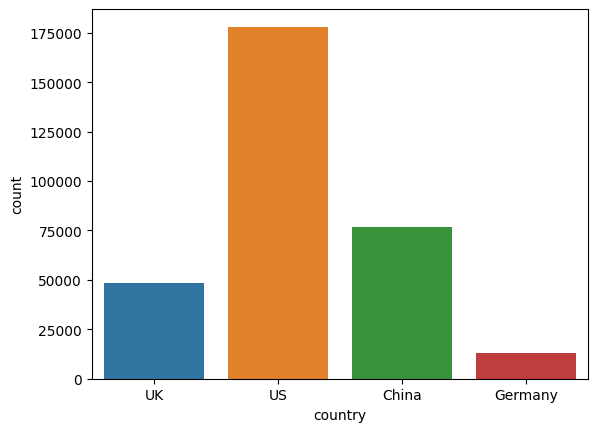

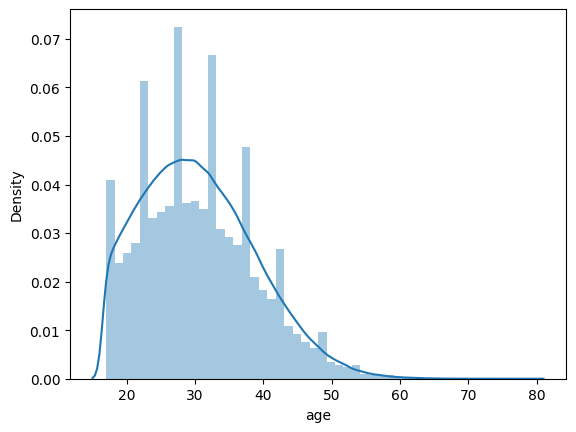

In [41]:
# For categorical variables
sns.countplot(x='country', data=df)
plt.show()

# For numerical variables
sns.distplot(df['age'])
plt.show()

### converstion rate by categories
To understand how different user characteristics influence conversion, we can calculate the conversion rate across different categories.
For instance, we can calculate the conversion rate by country, by marketing channel, and by whether they are a new user. Then, we can visualize these conversion rates using bar plots.

In [42]:
# Calculate conversion rates with country 
conversion_by_country = df.groupby('country')['converted'].mean()
conversion_by_country

country
China      0.001332
Germany    0.062428
UK         0.052612
US         0.037801
Name: converted, dtype: float64

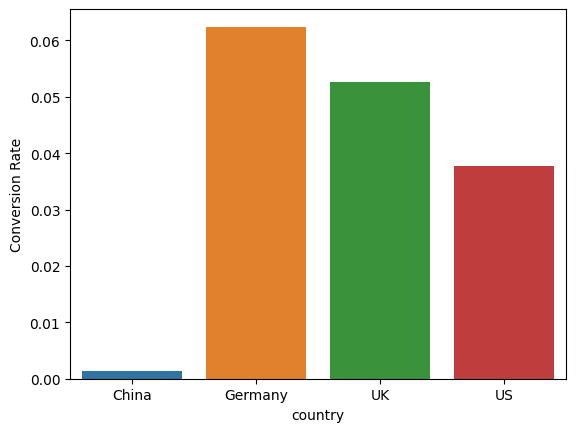

In [43]:
# Visualize conversion rates
sns.barplot(x=conversion_by_country.index, y=conversion_by_country.values)
plt.ylabel('Conversion Rate')
plt.show()

In [44]:
# Calculate conversion rates with source  
conversion_by_source = df.groupby('source')['converted'].mean()
conversion_by_source

source
Ads       0.034472
Direct    0.028169
Seo       0.032888
Name: converted, dtype: float64

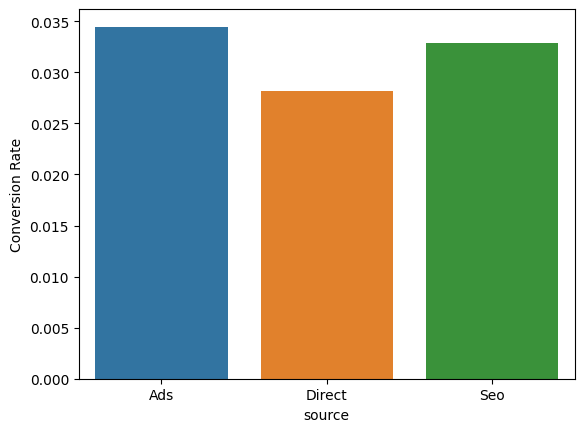

In [46]:
# Visualize conversion rates
sns.barplot(x=conversion_by_source.index, y=conversion_by_source.values)
plt.ylabel('Conversion Rate')
plt.show()

There are not much difference in sources and conversion rate, maybe we can look at each on specifically

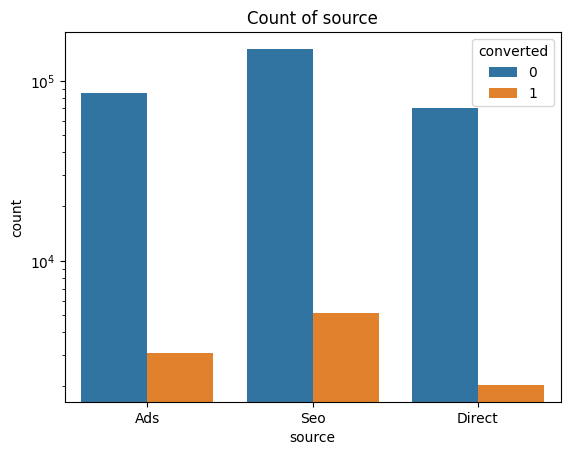

In [48]:
sns.countplot(x='source', hue='converted', data=df)
plt.title('Count of source')
plt.yscale('log');

All of them have pretty good conversion rates

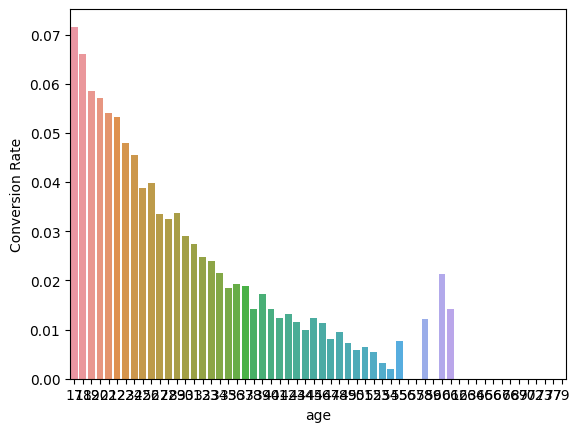

In [50]:
# Calculate conversion rates with age  
conversion_by_age = df.groupby('age')['converted'].mean()
conversion_by_age

# Visualize conversion rates
sns.barplot(x=conversion_by_age.index, y=conversion_by_age.values)
plt.ylabel('Conversion Rate')
plt.show()

Right now we can say that younger people have a higher conversion rate. To have a more detailed look into age groups, we need to put converted and unconverted groups together and visualize them with different age groups.

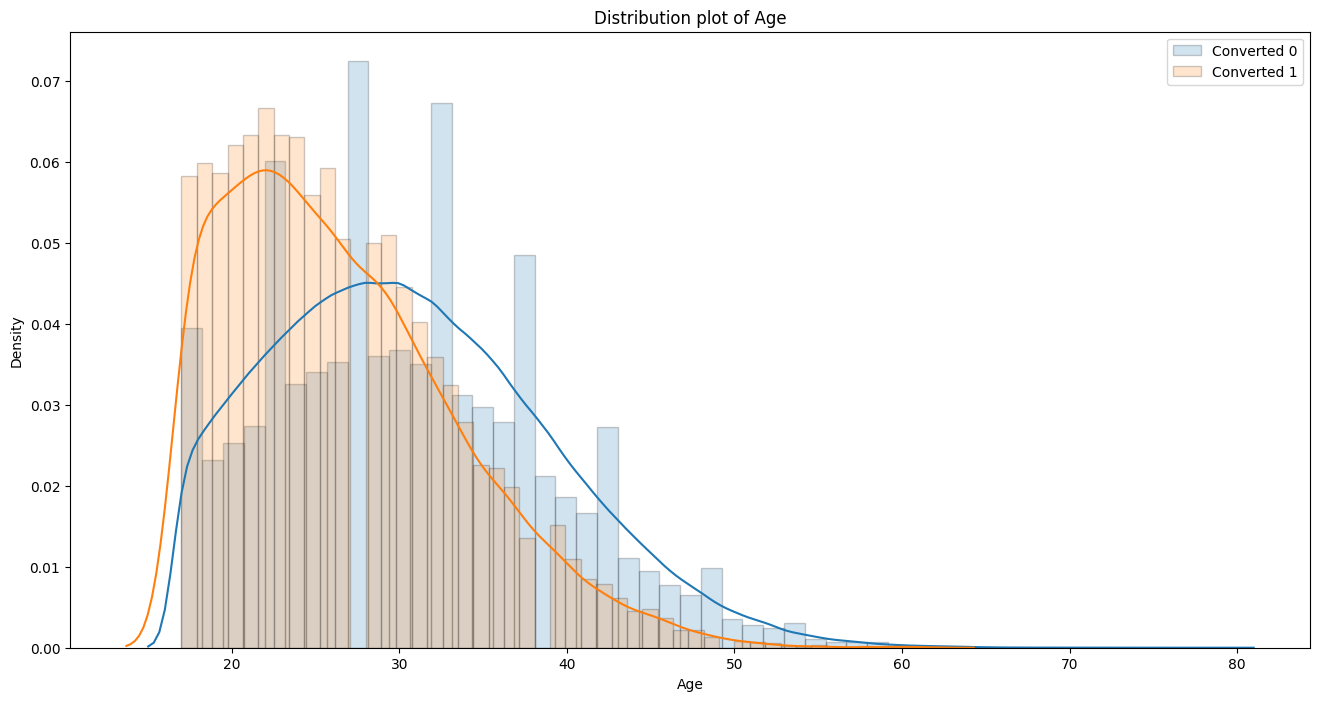

In [52]:
hist_kws = {'histtype':'bar', 'edgecolor':'black', 'alpha': 0.2}

plt.figure(figsize=(16,8))
sns.distplot(df[df['converted'] == 0]['age'], label='Converted 0', hist_kws = hist_kws)
sns.distplot(df[df['converted'] == 1]['age'], label='Converted 1', hist_kws = hist_kws)
plt.legend()
plt.title('Distribution plot of Age')
plt.xlabel('Age');

Generally, with the increasing of age, the converted rate keep decreasing (negative correlation)

## 3. Data preprocessing for ML

Scikit-learn models require numerical input, so we need to convert categorical variables into numerical. We can do this using 'pd.get_dummies()' function, which is a very straightforward way to encode categorical variables.

In [56]:
# Perform one-hot encoding and concatenate the new columns to the original dataframe
df_country = pd.get_dummies(df['country'], drop_first=True)
df_source = pd.get_dummies(df['source'], drop_first=True)
df = pd.concat([df, df_country, df_source], axis=1)

# Now you can drop the original 'country' and 'source' columns
df = df.drop(['country', 'source'], axis=1)
df.head()

,age,new_user,total_pages_visited,converted,Germany,UK,US,Direct,Seo
0,25,1,1,0,0,1,0,0,0
1,23,1,5,0,0,0,1,0,1
2,28,1,4,0,0,0,1,0,1
3,39,1,5,0,0,0,0,0,1
4,30,1,6,0,0,0,1,0,1


In [57]:
# Separate features and target
X = df.drop('converted', axis=1)
y = df['converted']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## 4. ML using logistic regression

In [58]:
# Instantiate the model
logreg = LogisticRegression(max_iter=1000)  # Increased max_iter to ensure convergence

# Fit the model to the training data
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [59]:
intercept = logreg.intercept_
coeff = logreg.coef_
coef_list = list(coeff[0,:])
coef_df = pd.DataFrame({'Feature': list(X_train.columns),'Coefficient': coef_list})
print(coef_df)

               Feature  Coefficient
0                  age    -0.075692
1             new_user    -1.740539
2  total_pages_visited     0.761250
3              Germany     3.548044
4                   UK     3.395572
5                   US     3.000428
6               Direct    -0.173732
7                  Seo    -0.006179


### model evaluation 

In [60]:
# Predict on the test data
y_pred = logreg.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     91848
           1       0.85      0.69      0.76      3012

    accuracy                           0.99     94860
   macro avg       0.92      0.84      0.88     94860
weighted avg       0.99      0.99      0.99     94860

[[91481   367]
 [  936  2076]]


To have a better understanding of how accurate if our matrix through confusion matrix

In [61]:
# Calculate the probabilities for each class
predicted_prob = logreg.predict_proba(X_test)[:, 1]

# Generate predicted class labels
y_pred = logreg.predict(X_test)

In [62]:
cm = pd.DataFrame(confusion_matrix(y_test, y_pred))
cm['Total'] = np.sum(cm, axis=1)
cm = cm.append(np.sum(cm, axis=0), ignore_index=True)
cm.columns = ['Predicted No', 'Predicted Yes', 'Total']
cm = cm.set_index([['Actual No', 'Actual Yes', 'Total']])

print(cm)

            Predicted No  Predicted Yes  Total
Actual No          91481            367  91848
Actual Yes           936           2076   3012
Total              92417           2443  94860


## Evaluate prediction on conversion rate using Random Forest

Now we have a rather accurate model, I want to understand how it actually make predictions. Random forest is a great model in this case for predicting conversion rate because it is good at dealing with outliers, irrelevant variables, continuous and discrete variables.

### Building and Training a Random Forest Model

In [63]:
# Instantiate the model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model to the training data
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### Model evaluation 

In [64]:
# Predict on the test data
y_pred_rf = rf.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred_rf))

# Confusion matrix
print(confusion_matrix(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     91848
           1       0.81      0.67      0.74      3012

    accuracy                           0.98     94860
   macro avg       0.90      0.83      0.86     94860
weighted avg       0.98      0.98      0.98     94860

[[91387   461]
 [  989  2023]]


### Check feature importance

In [65]:
# Get feature importance
importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': rf.feature_importances_})

# Sort by importance
importance = importance.sort_values(by='Importance', ascending=False)

print(importance)

               Feature  Importance
2  total_pages_visited    0.806424
0                  age    0.112070
1             new_user    0.038223
5                   US    0.012979
4                   UK    0.012641
3              Germany    0.008703
7                  Seo    0.005038
6               Direct    0.003923


### Visualize with simple decision tree

[Text(0.5, 0.875, 'total_pages_visited <= 12.5\ngini = 0.063\nsamples = 221340\nvalue = [214152, 7188]\nclass = Not Converted'),
 Text(0.25, 0.625, 'total_pages_visited <= 10.5\ngini = 0.02\nsamples = 214406\nvalue = [212217, 2189]\nclass = Not Converted'),
 Text(0.125, 0.375, 'total_pages_visited <= 8.5\ngini = 0.01\nsamples = 208099\nvalue = [207005, 1094]\nclass = Not Converted'),
 Text(0.0625, 0.125, 'gini = 0.005\nsamples = 193883\nvalue = [193428, 455]\nclass = Not Converted'),
 Text(0.1875, 0.125, 'gini = 0.086\nsamples = 14216\nvalue = [13577, 639]\nclass = Not Converted'),
 Text(0.375, 0.375, 'new_user <= 0.5\ngini = 0.287\nsamples = 6307\nvalue = [5212, 1095]\nclass = Not Converted'),
 Text(0.3125, 0.125, 'gini = 0.445\nsamples = 2372\nvalue = [1579, 793]\nclass = Not Converted'),
 Text(0.4375, 0.125, 'gini = 0.142\nsamples = 3935\nvalue = [3633, 302]\nclass = Not Converted'),
 Text(0.75, 0.625, 'total_pages_visited <= 14.5\ngini = 0.402\nsamples = 6934\nvalue = [1935, 4999]\

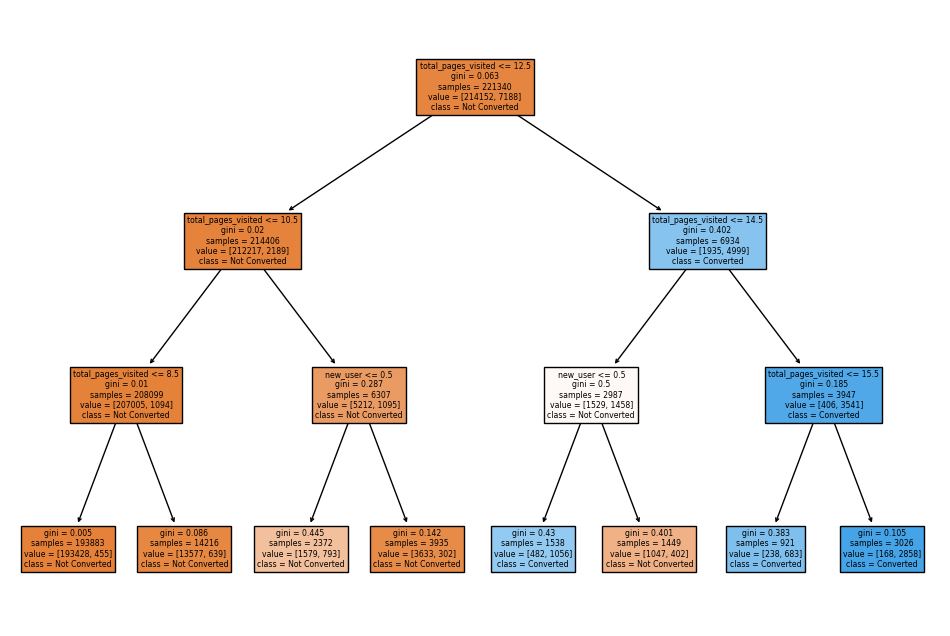

In [70]:
# Instantiate the model
tree = DecisionTreeClassifier(max_depth=3, random_state=42)

# Fit the model
tree.fit(X_train, y_train)

# Plot the tree
plt.figure(figsize=(12,8))
plot_tree(tree, feature_names=X_train.columns, class_names=['Not Converted', 'Converted'], filled=True)

Some conclusions and suggestions:
1. The site is working very well for **young users**. Definitely let’s tell marketing to advertise and use marketing channel which are more likely to reach young people.
2. The site is working very well for **Germany** in terms of conversion. But the summary showed that there are **few Germans coming to the site**: way less than UK, despite a larger population. Again, marketing should get more Germans. Big opportunity.
3. Users with **old accounts** do much better. Targeted emails with offers to bring them back to the site could be a good idea to try.
4. Something is wrong with the **Chinese** version of the site. It is either poorly translated, doesn’t fit the local culture, some payment issue or maybe it is just in English! Given how many users are based in China, fixing this should be a top priority. Huge opportunity.
5. Maybe go through the UI and figure out why **older users** perform so poorly? From 30 y/o conversion clearly starts dropping.
6. If I know someone has **visited many pages**, but hasn’t converted, she almost surely has high purchase intent. I could email her targeted offers or sending her reminders. Overall, these are probably the easiest users to make convert.